In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from math import gcd
from fractions import Fraction
import imageio
import os

def plot_phasor_diagram(Q, p, m, gif_filename='phasor_diagram.gif'):
    """
    Generates a phasor diagram for an electric motor as a .gif, showing phasors added step by step.
    
    Parameters:
    - Q: Total number of slots in the motor.
    - p: Total number of poles in the motor.
    - m: Number of phases in the motor (e.g., 3 for a three-phase motor).
    - gif_filename: Name of the output .gif file.
    
    Returns:
    - A list of [phasor_number, normalized_angle, phase, layer] quadruples.
    - Saves a .gif to gif_filename showing the diagram's construction.
    """
    # --- Calculate derived parameters ---
    PP = int(p / 2)
    t = gcd(Q, PP)
    Qp = Q / t
    phasors_per_layer = int(Qp)
    q = Fraction(Q, p * m)
    z = q.numerator
    n = q.denominator

    # --- Calculate angular displacements ---
    if t == PP:
        alpha_u = 360 * PP / Q
        alpha_z = alpha_u
    else:
        alpha_z = 360 / Qp
        if n % 2 != 0:
            alpha_u = n * alpha_z
        else:
            alpha_u = n / 2 * alpha_z

    # --- Define layer radii ---
    radii = [1 + 0.5 * i for i in range(t)]

    # --- Initialize plotting parameters ---
    current_angle = 90
    head_length = 0.05
    U_phasors = []
    phasor_angles = []
    phasor_number = 1

    # --- Initialize frame storage ---
    frames = []

    # --- Create initial empty plot ---
    def setup_plot():
        fig, ax = plt.subplots(figsize=(5, 5), dpi=150)
        ax.set_aspect('equal')
        ax.grid(True, color='lightgray', linestyle='--', linewidth=0.5, alpha=0.5)
        max_radius = max(radii) if radii else 1
        ax.set_xlim(-max_radius - 0.5, max_radius + 0.5)
        ax.set_ylim(-max_radius - 0.5, max_radius + 0.5)
        ax.set_xlabel('Real')
        ax.set_ylabel('Imaginary')
        ax.set_title('Phasor Diagram')
        return fig, ax

    # --- Collect phasor data and create frames ---
    for layer in range(t):
        radius = radii[layer]
        shaft_scale = 1 - (head_length / radius)
        
        for i in range(phasors_per_layer):
            # Create a new plot for each frame
            fig, ax = setup_plot()
            
            # Redraw all phasors up to the current one
            for prev_phasor in phasor_angles:
                prev_number, prev_angle, prev_layer, (text_x, text_y) = prev_phasor
                prev_radius = radii[prev_layer]
                prev_shaft_scale = 1 - (head_length / prev_radius)
                angle_rad = np.deg2rad(prev_angle)
                x = prev_radius * prev_shaft_scale * np.cos(angle_rad)
                y = prev_radius * prev_shaft_scale * np.sin(angle_rad)
                color = 'red' if prev_number in U_phasors else 'black'
                ax.arrow(0, 0, x, y, head_width=0.04, head_length=0.05, fc=color, ec=color)
                # Placeholder for text (added later)
                ax.text(text_x, text_y, f"{prev_number}", fontsize=6, ha='center', va='center')
            
            # Add the current phasor
            normalized_angle = current_angle % 360
            angle_rad = np.deg2rad(current_angle)
            x = radius * shaft_scale * np.cos(angle_rad)
            y = radius * shaft_scale * np.sin(angle_rad)
            color = 'red' if phasor_number in U_phasors else 'black'
            ax.arrow(0, 0, x, y, head_width=0.04, head_length=0.05, fc=color, ec=color)
            
            # Calculate text position
            text_offset = 1.08 * radius
            text_angle_offset = 7
            text_x = text_offset * np.cos(angle_rad - text_angle_offset / 180 * np.pi)
            text_y = text_offset * np.sin(angle_rad - text_angle_offset / 180 * np.pi)
            ax.text(text_x, text_y, f"{phasor_number}", fontsize=6, ha='center', va='center')
            
            # Draw layer circles up to current layer
            for r in radii[:layer + 1]:
                circle = plt.Circle((0, 0), r, fill=False, color='gray')
                ax.add_patch(circle)
            
            # Save the frame
            frame_path = f'frame_{phasor_number}.png'
            plt.savefig(frame_path, bbox_inches='tight')
            frames.append(imageio.imread(frame_path))
            plt.close(fig)
            
            # Store phasor data
            phasor_angles.append([phasor_number, normalized_angle, layer, (text_x, text_y)])
            
            phasor_number += 1
            current_angle -= alpha_u

    # --- Sort phasors by layer and angle ---
    layered_phasors = [[] for _ in range(t)]
    for phasor in phasor_angles:
        layered_phasors[phasor[2]].append([phasor[0], phasor[1], phasor[2], phasor[3]])
    for layer_phasors in layered_phasors:
        layer_phasors.sort(key=lambda x: (x[1] - 90) % 360)
    sorted_phasors = []
    for layer_phasors in layered_phasors:
        sorted_phasors.extend(layer_phasors)

    # --- Assign phase designations ---
    elements_per_phase = int(Q / t / m / 2)
    phase_order = ["phase -U", "phase +W", "phase -V", "phase +U", "phase -W", "phase +V"]
    phase_assignments = []
    while len(phase_assignments) < Q:
        for phase in phase_order:
            phase_assignments.extend([phase] * elements_per_phase)
            if len(phase_assignments) >= Q:
                break
    phase_assignments = phase_assignments[:Q]

    # --- Create final plot with phase labels ---
    fig, ax = setup_plot()
    phasor_to_phase = {p[0]: phase_assignments[i] for i, p in enumerate(sorted_phasors)}
    phase_short_map = {
        "phase -U": "-U", "phase +W": "+W", "phase -V": "-V",
        "phase +U": "+U", "phase -W": "-W", "phase +V": "+V"
    }
    
    for phasor in phasor_angles:
        phasor_number, normalized_angle, layer, (text_x, text_y) = phasor
        radius = radii[layer]
        shaft_scale = 1 - (head_length / radius)
        angle_rad = np.deg2rad(normalized_angle)
        x = radius * shaft_scale * np.cos(angle_rad)
        y = radius * shaft_scale * np.sin(angle_rad)
        color = 'red' if phasor_number in U_phasors else 'black'
        ax.arrow(0, 0, x, y, head_width=0.04, head_length=0.05, fc=color, ec=color)
        phase = phasor_to_phase[phasor_number]
        label = f"{phasor_number} ({phase_short_map[phase]})"
        ax.text(text_x, text_y, label, fontsize=6, ha='center', va='center')
    
    for radius in radii:
        circle = plt.Circle((0, 0), radius, fill=False, color='gray')
        ax.add_patch(circle)
    
    # Save final frame
    frame_path = f'frame_final.png'
    plt.savefig(frame_path, bbox_inches='tight')
    frames.append(imageio.imread(frame_path))
    plt.close(fig)

    # --- Create GIF ---
    imageio.mimsave(gif_filename, frames, duration=0.5, loop=0)
    
    # --- Clean up temporary files ---
    for i in range(1, phasor_number):
        try:
            os.remove(f'frame_{i}.png')
        except:
            pass
    try:
        os.remove('frame_final.png')
    except:
        pass

    # --- Create final array ---
    phasor_angles_with_phase = [[p[0], p[1], phase_assignments[i], p[2]] for i, p in enumerate(sorted_phasors)]
    return phasor_angles_with_phase

# Generate diagram output and create GIF
diagram_output = plot_phasor_diagram(Q=12, p=10, m=3, gif_filename='phasor_diagram.gif')

ValueError: keyword label is not recognized; valid keywords are ['size', 'width', 'color', 'tickdir', 'pad', 'labelsize', 'labelcolor', 'labelfontfamily', 'zorder', 'gridOn', 'tick1On', 'tick2On', 'label1On', 'label2On', 'length', 'direction', 'left', 'bottom', 'right', 'top', 'labelleft', 'labelbottom', 'labelright', 'labeltop', 'labelrotation', 'grid_agg_filter', 'grid_alpha', 'grid_animated', 'grid_antialiased', 'grid_clip_box', 'grid_clip_on', 'grid_clip_path', 'grid_color', 'grid_dash_capstyle', 'grid_dash_joinstyle', 'grid_dashes', 'grid_data', 'grid_drawstyle', 'grid_figure', 'grid_fillstyle', 'grid_gapcolor', 'grid_gid', 'grid_in_layout', 'grid_label', 'grid_linestyle', 'grid_linewidth', 'grid_marker', 'grid_markeredgecolor', 'grid_markeredgewidth', 'grid_markerfacecolor', 'grid_markerfacecoloralt', 'grid_markersize', 'grid_markevery', 'grid_mouseover', 'grid_path_effects', 'grid_picker', 'grid_pickradius', 'grid_rasterized', 'grid_sketch_params', 'grid_snap', 'grid_solid_capstyle', 'grid_solid_joinstyle', 'grid_transform', 'grid_url', 'grid_visible', 'grid_xdata', 'grid_ydata', 'grid_zorder', 'grid_aa', 'grid_c', 'grid_ds', 'grid_ls', 'grid_lw', 'grid_mec', 'grid_mew', 'grid_mfc', 'grid_mfcalt', 'grid_ms']

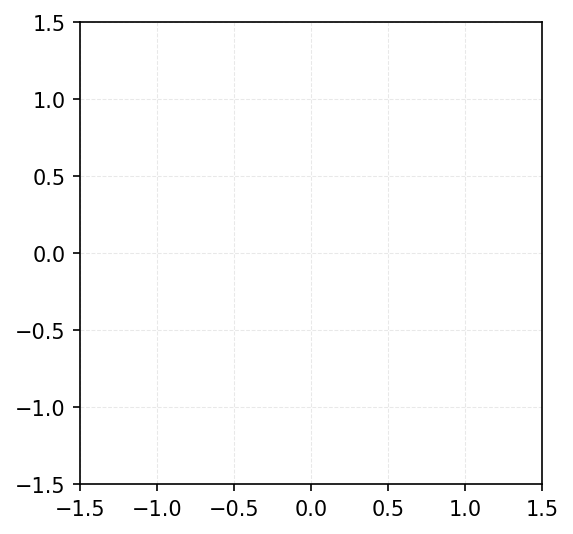

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from math import gcd
from fractions import Fraction
import imageio
import os

def plot_phasor_diagram(Q, p, m):
    """
    Generates a phasor diagram for an electric motor and creates animation frames to show
    the step-by-step construction of phasors. Returns the phasor data and frames for .gif creation.
    
    Parameters:
    - Q (int): Total number of slots in the motor (e.g., 12).
    - p (int): Total number of poles in the motor (e.g., 10).
    - m (int): Number of phases in the motor (e.g., 3 for a three-phase motor).
    
    Returns:
    - phasor_angles_with_phase (list): List of [phasor_number, normalized_angle, phase, layer]
      quadruples, where:
        - phasor_number: Integer from 1 to Q identifying each phasor.
        - normalized_angle: Angle in degrees [0, 360) for the phasor's position.
        - phase: Phase designation (e.g., "phase -U", "phase +W").
        - layer: Layer index (0 to t-1, where t is the number of layers).
      Sorted by layer, then by normalized_angle within each layer.
    - frames (list): List of image arrays (from matplotlib plots) for the .gif animation.
    
    Notes:
    - Each frame shows the phasor diagram as phasors are added one by one, with temporary
      labels showing phasor numbers (e.g., "1").
    - The final frame includes phase labels (e.g., "1 (-U)") for the completed diagram.
    - Frames are saved as temporary .png files and read into image arrays.
    - Uses consistent figure size (8x6 inches, 150 DPI) to ensure uniform frame dimensions.
    """
    # --- Calculate derived parameters for the motor configuration ---
    # PP: Number of pole-pairs, half the total number of poles
    PP = int(p / 2)
    # t: Greatest common divisor of Q and PP, determines the number of layers in the diagram
    t = gcd(Q, PP)
    # Qp: Number of phasors per layer, calculated as Q divided by t
    Qp = Q / t
    # phasors_per_layer: Integer number of phasors in each layer
    phasors_per_layer = int(Qp)
    # q: Fraction representing slots per pole per phase (Q / (p * m))
    q = Fraction(Q, p * m)
    # z: Numerator of q, used in winding calculations
    z = q.numerator
    # n: Denominator of q, determines winding type (odd for first-grade, even for second-grade)
    n = q.denominator

    # --- Calculate angular displacements for phasor positioning ---
    # alpha_u: Angular displacement between consecutive phasors in degrees
    # alpha_z: Base angle for phasor spacing
    if t == PP:
        # Case 1: When t equals PP (integral slot winding), use standard angle calculation
        alpha_u = 360 * PP / Q
        alpha_z = alpha_u
    else:
        # Case 2: For fractional slot designs, adjust angles based on Pyrhonen's method
        alpha_z = 360 / Qp
        if n % 2 != 0:  # Odd n indicates first-grade winding
            alpha_u = n * alpha_z
        else:  # Even n indicates second-grade winding
            alpha_u = n / 2 * alpha_z

    # --- Define layer radii for multi-layer diagrams ---
    # Each layer is plotted at a different radius to avoid overlap
    # Radius starts at 1 and increases by 0.5 per layer (e.g., [1] for t=1, [1, 1.5] for t=2)
    radii = [1 + 0.5 * i for i in range(t)]

    # --- Initialize plotting parameters ---
    # current_angle: Starting angle for the first phasor (90 degrees, top of the plot)
    current_angle = 90
    # head_length: Length of arrowheads for phasor arrows (kept small for clarity)
    head_length = 0.05
    # U_phasors: List of phasor numbers to color red (empty in this case, but customizable)
    U_phasors = []
    # phasor_angles: Temporary storage for phasor data [number, angle, layer, text_coords]
    phasor_angles = []
    # frames: List to store image arrays for the .gif animation
    frames = []
    # phasor_number: Counter for assigning phasor numbers, starting at 1
    phasor_number = 1

    # --- Define a helper function to set up a new plot for each frame ---
    def setup_plot():
        """
        Creates a new matplotlib figure and axis for a phasor diagram frame.
        
        Returns:
        - fig: Matplotlib figure object.
        - ax: Matplotlib axis object with equal aspect ratio and grid.
        """
        # Create a figure of size 8x6 inches with 150 DPI for consistent frame dimensions
        fig, ax = plt.subplots(figsize=(6, 4), dpi=150)
        # Set equal aspect ratio to ensure circular appearance
        ax.set_aspect('equal')
        # Add a light gray grid for better visualization
        ax.grid(True, color='lightgray', linestyle='--', linewidth=0.5, alpha=0.5)
        # Set plot limits based on the maximum radius to ensure all phasors are visible
        max_radius = max(radii) if radii else 1
        ax.set_xlim(-max_radius - 0.5, max_radius + 0.5)
        ax.set_ylim(-max_radius - 0.5, max_radius + 0.5)

        # # Remove tick params for x and y axes
        ax.tick_params(axis='x', which='major', labelbottom=False)
        ax.tick_params(axis='y', which='major', labelleft=False)
        # Label axes for real and imaginary components
        # ax.set_xlabel('Real', fontsize = 8)
        # ax.set_ylabel('Imaginary', fontsize = 8)
        # Set title for the phasor diagram
        ax.set_title('Phasor Diagram', fontsize = 8)
        return fig, ax

    # --- Generate frames by adding phasors one by one ---
    # Iterate over each layer (0 to t-1)
    for layer in range(t):
        # Get the radius for the current layer (e.g., 1 for layer 0, 1.5 for layer 1)
        radius = radii[layer]
        # Adjust shaft length so the arrow tip (including head) touches the circle
        shaft_scale = 1 - (head_length / radius)
        
        # Iterate over the number of phasors in the current layer
        for i in range(phasors_per_layer):
            # Create a new plot for the current frame
            fig, ax = setup_plot()
            
            # Redraw all previously added phasors to maintain continuity
            for prev_phasor in phasor_angles:
                prev_number, prev_angle, prev_layer, (text_x, text_y) = prev_phasor
                prev_radius = radii[prev_layer]
                prev_shaft_scale = 1 - (head_length / prev_radius)
                # Convert angle to radians for trigonometric calculations
                angle_rad = np.deg2rad(prev_angle)
                # Calculate arrow coordinates, scaled to account for arrowhead
                x = prev_radius * prev_shaft_scale * np.cos(angle_rad)
                y = prev_radius * prev_shaft_scale * np.sin(angle_rad)
                # Color phasor red if in U_phasors, else black
                color = 'red' if prev_number in U_phasors else 'black'
                # Draw the arrow from origin to (x, y)
                ax.arrow(0, 0, x, y, head_width=0.04, head_length=0.05, fc=color, ec=color)
                # Add temporary label with phasor number (e.g., "1")
                ax.text(text_x, text_y, f"{prev_number}", fontsize=6, ha='center', va='center')
            
            # --- Plot the current phasor ---
            # Normalize the angle to [0, 360) to avoid negative/large values
            normalized_angle = current_angle % 360
            # Convert to radians for plotting
            angle_rad = np.deg2rad(current_angle)
            # Calculate arrow coordinates
            x = radius * shaft_scale * np.cos(angle_rad)
            y = radius * shaft_scale * np.sin(angle_rad)
            # Set color based on U_phasors
            color = 'red' if phasor_number in U_phasors else 'black'
            # Draw the current phasor as an arrow
            ax.arrow(0, 0, x, y, head_width=0.04, head_length=0.05, fc=color, ec=color)
            
            # --- Add text label for the current phasor ---
            # Position text slightly beyond the arrow tip for clarity
            text_offset = 1.08 * radius
            text_angle_offset = 7  # Small angle offset to avoid overlap
            text_x = text_offset * np.cos(angle_rad - text_angle_offset / 180 * np.pi)
            text_y = text_offset * np.sin(angle_rad - text_angle_offset / 180 * np.pi)
            # Add temporary phasor number label
            ax.text(text_x, text_y, f"{phasor_number}", fontsize=6, ha='center', va='center')
            
            # --- Draw layer circles for current and previous layers ---
            # Only draw circles up to the current layer to show progression
            for r in radii[:layer + 1]:
                circle = plt.Circle((0, 0), r, fill=False, color='gray')
                ax.add_patch(circle)
            
            # --- Save the frame as a temporary .png file ---
            frame_path = f'frame_phasor_{phasor_number}.png'
            plt.savefig(frame_path, bbox_inches='tight')
            # Read the .png into an image array for the .gif
            frames.append(imageio.imread(frame_path))
            # Close the figure to free memory
            plt.close(fig)
            
            # --- Store phasor data for later sorting and phase assignment ---
            phasor_angles.append([phasor_number, normalized_angle, layer, (text_x, text_y)])
            
            # Increment phasor number and move to the next angle (clockwise)
            phasor_number += 1
            current_angle -= alpha_u

    # --- Sort phasors by layer and angle for consistent ordering ---
    # Create a list of t empty lists to group phasors by layer
    layered_phasors = [[] for _ in range(t)]
    # Assign each phasor to its layer
    for phasor in phasor_angles:
        layered_phasors[phasor[2]].append([phasor[0], phasor[1], phasor[2], phasor[3]])
    # Sort each layer's phasors by angle, starting at 90 degrees
    # The key (x[1] - 90) % 360 maps 90° to 0, 91° to 1, ..., 89° to 359
    for layer_phasors in layered_phasors:
        layer_phasors.sort(key=lambda x: (x[1] - 90) % 360)
    # Combine sorted layers into a single list (layer 0, then layer 1, etc.)
    sorted_phasors = []
    for layer_phasors in layered_phasors:
        sorted_phasors.extend(layer_phasors)

    # --- Assign phase designations to phasors ---
    # Each phase group has Q/(t*m*2) phasors (positive and negative phases)
    elements_per_phase = int(Q / t / m / 2)
    # Define the order of phases to cycle through
    phase_order = ["phase -U", "phase +W", "phase -V", "phase +U", "phase -W", "phase +V"]
    # Generate phase assignments for all Q phasors
    phase_assignments = []
    while len(phase_assignments) < Q:
        for phase in phase_order:
            phase_assignments.extend([phase] * elements_per_phase)
            if len(phase_assignments) >= Q:
                break
    phase_assignments = phase_assignments[:Q]

    # --- Create the final frame with phase labels ---
    # Set up a new plot for the final frame
    fig, ax = setup_plot()
    # Create a mapping from phasor number to phase for label assignment
    phasor_to_phase = {p[0]: phase_assignments[i] for i, p in enumerate(sorted_phasors)}
    # Define short forms for phase labels (e.g., "phase -U" -> "-U")
    phase_short_map = {
        "phase -U": "-U", "phase +W": "+W", "phase -V": "-V",
        "phase +U": "+U", "phase -W": "-W", "phase +V": "+V"
    }
    
    # Redraw all phasors with final labels
    for phasor in phasor_angles:
        phasor_number, normalized_angle, layer, (text_x, text_y) = phasor
        radius = radii[layer]
        shaft_scale = 1 - (head_length / radius)
        angle_rad = np.deg2rad(normalized_angle)
        x = radius * shaft_scale * np.cos(angle_rad)
        y = radius * shaft_scale * np.sin(angle_rad)
        color = 'red' if phasor_number in U_phasors else 'black'
        ax.arrow(0, 0, x, y, head_width=0.04, head_length=0.05, fc=color, ec=color)
        # Get the phase and create the final label (e.g., "1 (-U)")
        phase = phasor_to_phase[phasor_number]
        label = f"{phasor_number} ({phase_short_map[phase]})"
        ax.text(text_x, text_y, label, fontsize=6, ha='center', va='center')
    
    # Draw all layer circles in the final frame
    for radius in radii:
        circle = plt.Circle((0, 0), radius, fill=False, color='gray')
        ax.add_patch(circle)
    
    # Save the final frame
    frame_path = f'frame_phasor_final.png'
    plt.savefig(frame_path, bbox_inches='tight')
    frames.append(imageio.imread(frame_path))
    plt.close(fig)

    # --- Create and return the final phasor data array ---
    # Format: [phasor_number, normalized_angle, phase, layer]
    phasor_angles_with_phase = [[p[0], p[1], phase_assignments[i], p[2]] for i, p in enumerate(sorted_phasors)]
    return phasor_angles_with_phase, frames

def generate_phasor_list_for_X_phase(diagram_output, phase):
    """
    Generates a list of phasors for a specified phase (U, V, or W) from the phasor diagram output.
    Includes both positive and negative phasors (e.g., "+U" and "-U").
    
    Parameters:
    - diagram_output (list): List of [phasor_number, normalized_angle, phase, layer] quadruples
      from plot_phasor_diagram.
    - phase (str): Target phase ("U", "V", or "W").
    
    Returns:
    - phasor_list (list): List of (phasor_number, magnitude, angle) tuples, where:
        - phasor_number: Integer identifying the phasor (1 to Q).
        - magnitude: 1 for positive phase (e.g., "phase +U"), -1 for negative (e.g., "phase -U").
        - angle: Normalized angle in degrees [0, 360).
    
    Raises:
    - ValueError: If phase is not "U", "V", or "W".
    
    Notes:
    - Used to extract phasors for plotting their geometric sum in plot_multiple_phasor_sum.
    - The magnitude and angle are used for vector calculations in the sum plot.
    """
    # Validate the phase parameter
    if phase not in ["U", "V", "W"]:
        raise ValueError("Phase must be 'U', 'V', or 'W'")
    
    # Initialize the list to store phasor tuples
    phasor_list = []
    # Define the positive and negative phase names (e.g., "phase +U", "phase -U")
    positive_phase = f"phase +{phase}"
    negative_phase = f"phase -{phase}"
    
    # Iterate through the diagram output to find phasors for the specified phase
    for phasor in diagram_output:
        phasor_number, normalized_angle, phase_name, layer = phasor
        if phase_name in [positive_phase, negative_phase]:
            # Assign magnitude: 1 for positive phase, -1 for negative phase
            magnitude = -1 if phase_name == negative_phase else 1
            # Add the phasor tuple to the list
            phasor_list.append((phasor_number, magnitude, normalized_angle))
    
    return phasor_list

def plot_multiple_phasor_sum(phasors, phase, input_thickness=0.005, resultant_thickness=0.007, resultant_color="green", resultant_label="Geometric sum"):
    """
    Generates animation frames for plotting the geometric sum of phasors for a given phase.
    Each frame adds one phasor, with the final frame including the resultant vector.
    
    Parameters:
    - phasors (list): List of (phasor_number, magnitude, angle) tuples, where:
        - phasor_number: Integer identifying the phasor.
        - magnitude: Float, typically 1 or -1 for positive/negative phase.
        - angle: Angle in degrees.
    - phase (str): Phase being plotted ("U", "V", or "W") for titling.
    - input_thickness (float): Thickness of input phasor arrows (default: 0.005).
    - resultant_thickness (float): Thickness of resultant arrow (default: 0.007).
    - resultant_color (str): Color of the resultant vector (e.g., "green" for U).
    - resultant_label (str): Label for the resultant vector (e.g., "Phase U").
    
    Returns:
    - frames (list): List of image arrays for the .gif animation.
    
    Notes:
    - Uses quiver() to plot phasor arrows with alternating black/grey colors.
    - The resultant vector is plotted in the final frame with a custom color.
    - Frames are saved as temporary .png files and read into image arrays.
    - Consistent figure size (8x6 inches, 150 DPI) ensures uniform frame dimensions.
    - Legend is placed inside the plot ('upper right') to avoid dimension mismatches.
    """
    # Initialize the list to store image arrays for the .gif
    frames = []
    
    # --- Define a helper function to set up a new plot for each frame ---
    def setup_plot():
        """
        Creates a new matplotlib figure and axis for a phasor sum frame.
        
        Returns:
        - fig: Matplotlib figure object.
        - ax: Matplotlib axis object with equal aspect ratio and grid.
        """
        # Create a figure of size 8x6 inches with 150 DPI
        fig, ax = plt.subplots(figsize=(8, 6), dpi=150)
        # Set equal aspect ratio for accurate vector representation
        ax.set_aspect('equal')
        # Add a light gray grid for visualization
        ax.grid(True, color='lightgray', linestyle='--', linewidth=0.5, alpha=0.5)
        # Add horizontal and vertical lines at origin for reference
        ax.axhline(y=0, color='k', linestyle='-', alpha=0.3)
        ax.axvline(x=0, color='k', linestyle='-', alpha=0.3)
        # Label axes for real and imaginary components
        ax.set_xlabel('Real')
        ax.set_ylabel('Imaginary')
        # Set title indicating the phase being plotted
        ax.set_title(f'Phase {phase} Phasor Sum')
        return fig, ax

    # --- Calculate vector components and plot limits ---
    # Initialize lists to store x and y components of each phasor
    x_components = []
    y_components = []
    # Convert each phasor's magnitude and angle to Cartesian coordinates
    for phasor_number, magnitude, angle in phasors:
        theta = np.radians(angle)
        x = magnitude * np.cos(theta)
        y = magnitude * np.sin(theta)
        x_components.append(x)
        y_components.append(y)
    
    # Calculate the resultant vector by summing components
    resultant_x = sum(x_components)
    resultant_y = sum(y_components)
    # Compute the magnitude of the resultant for setting plot limits
    magnitude_resultant = np.sqrt(resultant_x**2 + resultant_y**2)
    # Set plot limits to accommodate all phasors and the resultant
    max_range = max(magnitude_resultant, *[abs(mag) for _, mag, _ in phasors]) * 2

    # --- Generate frames for each phasor and the resultant ---
    # Initialize starting point for vector addition
    current_x = 0
    current_y = 0
    # Define alternating colors for phasor arrows
    cycle_colors = ['black', 'grey']
    num_colors = len(cycle_colors)
    
    # Create a frame for each phasor plus one for the resultant
    for i in range(len(phasors) + 1):
        # Set up a new plot for the frame
        fig, ax = setup_plot()
        # Set plot limits to ensure all vectors are visible
        ax.set_xlim(-max_range, max_range)
        ax.set_ylim(-max_range, max_range)
        
        # --- Redraw phasors up to the current index ---
        temp_x = 0
        temp_y = 0
        # Plot all phasors up to index i
        for j in range(min(i, len(phasors))):
            phasor_number, magnitude, angle = phasors[j]
            # Alternate between black and grey for visual distinction
            color = cycle_colors[j % num_colors]
            x = x_components[j]
            y = y_components[j]
            # Plot the phasor as a quiver arrow from (temp_x, temp_y) to (temp_x+x, temp_y+y)
            ax.quiver(temp_x, temp_y, x, y, angles='xy', scale_units='xy', scale=1,
                      color=color, width=input_thickness,
                      label=f'Phasor {phasor_number}: {magnitude}∠{angle}°')
            # Update the starting point for the next phasor
            temp_x += x
            temp_y += y
        
        # --- Add legend if phasors are present ---
        if i > 0:
            # Place legend inside the plot to maintain consistent frame dimensions
            ax.legend(loc='upper right', fontsize=8)
        
        # --- Save the frame ---
        frame_path = f'frame_sum_{phase}_{i}.png'
        plt.savefig(frame_path, bbox_inches='tight')
        frames.append(imageio.imread(frame_path))
        plt.close(fig)
        
        # --- Add the resultant vector in the final frame ---
        if i == len(phasors):
            # Set up a new plot for the final frame
            fig, ax = setup_plot()
            ax.set_xlim(-max_range, max_range)
            ax.set_ylim(-max_range, max_range)
            
            # Redraw all phasors
            temp_x = 0
            temp_y = 0
            for j in range(len(phasors)):
                phasor_number, magnitude, angle = phasors[j]
                color = cycle_colors[j % num_colors]
                x = x_components[j]
                y = y_components[j]
                ax.quiver(temp_x, temp_y, x, y, angles='xy', scale_units='xy', scale=1,
                          color=color, width=input_thickness,
                          label=f'Phasor {phasor_number}: {magnitude}∠{angle}°')
                temp_x += x
                temp_y += y
            
            # Calculate the resultant angle for labeling
            angle_resultant = np.degrees(np.arctan2(resultant_y, resultant_x))
            # Plot the resultant vector from origin to (resultant_x, resultant_y)
            ax.quiver(0, 0, resultant_x, resultant_y, angles='xy', scale_units='xy', scale=1,
                      color=resultant_color, width=resultant_thickness,
                      label=f'{resultant_label}: {magnitude_resultant:.2f}∠{angle_resultant:.1f}°')
            # Add legend with all phasors and resultant
            ax.legend(loc='upper right', fontsize=8)
            
            # Save the final frame
            frame_path = f'frame_sum_{phase}_final.png'
            plt.savefig(frame_path, bbox_inches='tight')
            frames.append(imageio.imread(frame_path))
            plt.close(fig)
    
    return frames

def generate_separate_gifs(Q=12, p=10, m=3, diagram_gif='phasor_diagram.gif', sum_gif='phasor_sum.gif'):
    """
    Generates two separate .gif files: one for the phasor diagram animation and one for
    the phasor sum animations of phases U, V, and W.
    
    Parameters:
    - Q (int): Total number of slots in the motor (default: 12).
    - p (int): Total number of poles in the motor (default: 10).
    - m (int): Number of phases in the motor (default: 3).
    - diagram_gif (str): Filename for the phasor diagram .gif (default: 'phasor_diagram.gif').
    - sum_gif (str): Filename for the phasor sum .gif (default: 'phasor_sum.gif').
    
    Notes:
    - The phasor diagram .gif shows phasors added one by one, with the final frame including
      phase labels (e.g., "1 (-U)").
    - The phasor sum .gif shows, for each phase (U, V, W), phasors added one by one,
      followed by the resultant vector (green for U, red for V, blue for W).
    - Each frame lasts 2.0 seconds (slower than the previous 1.0 seconds) for better visibility
      and to allow detailed observation of each step.
    - Both .gifs loop infinitely (loop=0).
    - Temporary .png files are created for frames and cleaned up afterward.
    - Uses consistent figure sizes (8x6 inches, 150 DPI) to ensure uniform frame dimensions.
    """
    # --- Generate phasor diagram data and animation frames ---
    # Call plot_phasor_diagram to get phasor data and frames
    diagram_output, diagram_frames = plot_phasor_diagram(Q, p, m)
    
    # --- Save the phasor diagram .gif ---
    # Compile frames into a .gif with 2.0-second duration per frame to slow down the animation
    # duration is in seconds, so 2.0 means each frame is displayed for 2 seconds, making the
    # total animation ~26 seconds for 13 frames
    imageio.mimsave(diagram_gif, diagram_frames, duration=0.5, loop=0, format='GIF-PIL')
    
    # --- Define phases and corresponding colors for the sum plots ---
    phases = ["U", "V", "W"]
    phases_color = ["green", "red", "blue"]
    
    # --- Generate phasor sum frames for each phase ---
    sum_frames = []
    for phase, phase_color in zip(phases, phases_color):
        # Extract phasors for the current phase (e.g., both "+U" and "-U")
        phasor_list = generate_phasor_list_for_X_phase(diagram_output, phase)
        # Generate animation frames for the phase's phasor sum
        phase_frames = plot_multiple_phasor_sum(
            phasors=phasor_list,
            phase=phase,
            input_thickness=0.005,  # Thickness for input phasor arrows
            resultant_thickness=0.007,  # Thickness for resultant arrow
            resultant_color=phase_color,  # Color for resultant (e.g., green for U)
            resultant_label=f"Phase {phase}"  # Label for resultant (e.g., "Phase U")
        )
        # Add the phase's frames to the sum_frames list
        sum_frames.extend(phase_frames)
    
    # --- Save the phasor sum .gif ---
    # Compile all phase frames (U, then V, then W) into a single .gif with 2.0-second duration
    # total animation is ~18 seconds for 9 frames (3 per phase * 3 phases)
    imageio.mimsave(sum_gif, sum_frames, duration=0.5, loop=0, format='GIF-PIL')
    
    # --- Clean up temporary .png files ---
    # Remove phasor diagram frame files
    for i in range(1, Q + 1):
        try:
            os.remove(f'frame_phasor_{i}.png')
        except:
            pass  # Ignore if file doesn't exist
    try:
        os.remove('frame_phasor_final.png')
    except:
        pass
    # Remove phasor sum frame files for each phase
    for phase in phases:
        # Account for phasor frames plus the resultant frame
        for i in range(len(generate_phasor_list_for_X_phase(diagram_output, phase)) + 2):
            try:
                os.remove(f'frame_sum_{phase}_{i}.png')
            except:
                pass
            try:
                os.remove(f'frame_sum_{phase}_final.png')
            except:
                pass

# --- Execute the script to generate both .gifs ---
# Use default parameters: Q=12 slots, p=10 poles, m=3 phases
# Output files: phasor_diagram.gif and phasor_sum.gif
generate_separate_gifs(Q=12, p=10, m=3, diagram_gif='phasor_diagram.gif', sum_gif='phasor_sum.gif')